In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import plotly.offline as plyo
import cufflinks as cf

In [76]:
url = 'https://github.com/jwkuyper/IOWA_test/blob/main/Dataset_V1.xlsx?raw=true'
df = pd.read_excel(url,sheet_name='Sheet1', parse_dates=['date'] )
df.head(5)

,iso_code,continent,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,...,positive_rate,stringency_index,population,population_density,median_age,gdp_per_capita,female_smokers,male_smokers,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,NaN,38928341.0,54.422,18.6,1803.987,NaN,NaN,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,38928341.0,54.422,18.6,1803.987,NaN,NaN,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,38928341.0,54.422,18.6,1803.987,NaN,NaN,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,38928341.0,54.422,18.6,1803.987,NaN,NaN,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,NaN,0.0,NaN,0.0,NaN,0.0,...,NaN,0.0,38928341.0,54.422,18.6,1803.987,NaN,NaN,0.5,64.83


In [77]:
# Filling all the null/NaN values of new* with 0
def FillNullWithZero(Dataframe, ColName):
    if ColName.startswith("new") or ColName.startswith("total") or "smokers" in ColName:
        Dataframe = Dataframe.fillna(value = {ColName:0})
    else:
        pass
    return Dataframe

for i in range(len(df.columns)):
    df = FillNullWithZero(df, df.columns[i])

In [78]:
#Dropping the rows which does not have any continent 
#Comment to be deleted: Dropping these 586 entries as these are identified as World and International, also most of their other features are all null
df.drop(df[df.continent.isnull()].index, inplace=True)

#comment TBD: My recommendation is to ddrop positive_rate column too.
df = df.drop("positive_rate", axis=1)

df = df.fillna(value={"stringency_index": df.stringency_index.mean(),
                      "population_density": df.population_density.min(),
                      "median_age": df.median_age.mean(),
                      "gdp_per_capita":df.gdp_per_capita.mean(),
                      "hospital_beds_per_thousand":df.hospital_beds_per_thousand.mean(),
                      "life_expectancy": df.life_expectancy.mean()
                     }
              )

In [79]:
null_columns=df.columns[df.isnull().any()]
df[null_columns].isnull().sum()

print(df[df.isnull().any(axis=1)][null_columns].head(10))

Empty DataFrame
Columns: []
Index: []


In [80]:
df2 = df.copy()

In [81]:
def CreateCorrPlot(df2):
    sns.set(style="white")
    f, ax = plt.subplots(figsize=(11, 9))
    
    sns.heatmap(df2.corr()
                ,mask=np.triu(np.ones_like(df2.corr(), dtype=np.bool))
                ,cmap=sns.diverging_palette(220, 10, as_cmap=True)
                ,vmax=.3, center=0
                ,square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

This visual was important to our analysis as we used it to identify lesser correlated features to remove from our linear regression model during our refining process.

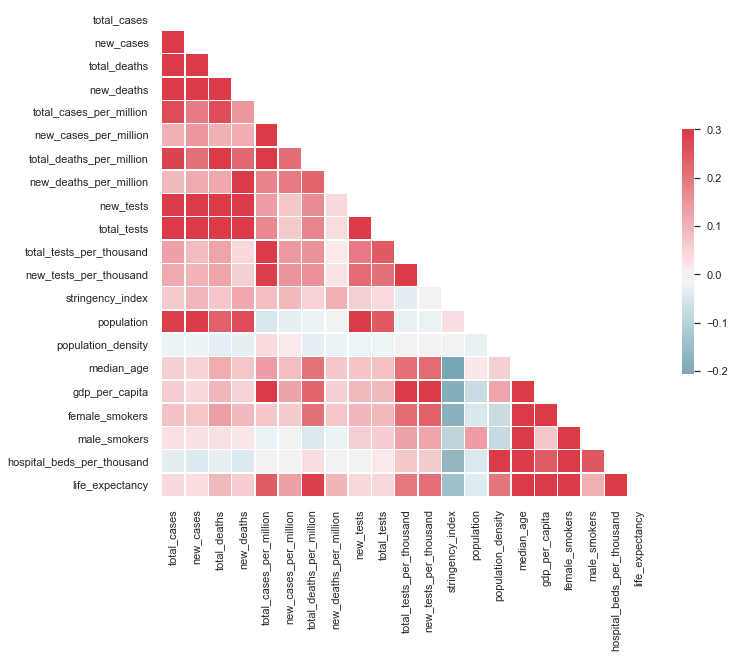

In [82]:
CreateCorrPlot(df2[list(df.columns)])

Based on correlation visual above, we chose to remove:
'female_smokers',
'male_smokers',
'gdp_per_capita',
'hospital_beds_per_thousand',
'population_density',
'stringency_index'

In [83]:
df.drop(['female_smokers', 'male_smokers', 'gdp_per_capita', 'hospital_beds_per_thousand',
         'population_density','stringency_index'], axis=1,inplace=True)

In [84]:
series = df2[(df2.location=="World")]
series = df2.groupby('date').total_deaths.sum()
plyo.iplot(series.iplot(asFigure=True
                          ,title='World Deaths Over Time'
                          ,theme='polar'
                          ,xTitle='Date'
                          ,yTitle='Total Deaths'))

In [85]:
# Function to plot the data by Location and any attribute (column name)
def PlotPerCountry(DataFrame, CountryName,name_of_column):
    if CountryName in DataFrame.location.values and name_of_column in DataFrame.columns:
        tdf = DataFrame[DataFrame.location == CountryName]
        series = tdf[(tdf.location==CountryName)]
        series = tdf.groupby('date')[name_of_column].sum()
        plyo.iplot(series.iplot(asFigure=True
                                ,title=str(CountryName)+' '+str(name_of_column)+' Over Time'
                                ,theme='polar'
                                ,xTitle='Date'
                                ,yTitle=name_of_column))
    else:
        print("Oops!  That was not valid country or column name.  Try again...")



#PlotPerCountry(df2, "World","total_deaths") This cannot be done as I have dropped all the rows where continent is NaN
PlotPerCountry(df2, "United States","total_deaths")
PlotPerCountry(df2, "India","new_cases")
PlotPerCountry(df2, "abc","xyz")

Oops!  That was not valid country or column name.  Try again...


In [86]:
df.iso_code = pd.Categorical(df.iso_code)
df.iso_code = df.iso_code.cat.codes
df.sample(n=10, replace=False).to_csv(path_or_buf= 'sample.csv', index=False)

In [87]:
df.drop(['continent', 'location', 'date'], axis=1,inplace=True)

Serializing dataframe into byte stream using the Pickle module, 'pickle'

In [88]:
import pickle

with open("df.pkl", "wb") as fwb:
    pickle.dump(df, fwb)